# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

**Оценка** 1.5 + 0.5 + 0.5 + 1.5 + 0.5 + 1.5 + 0.1 = 6.1

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [5]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [6]:
X = pd.DataFrame(data)
y = pd.DataFrame(target)

In [7]:
X.shape, y.shape

((506, 13), (506, 1))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [8]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.44763139462383

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [82]:
from tqdm import tqdm

def compute_biase_variance(regressor, X, y, num_runs=100):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    n_obj = X.shape[0]
    a = (n_obj, 1)

    preds_sum = np.zeros(a)
    preds_sum_sqrd = np.zeros(a)
    preds_q = np.zeros(a)

    preds_count = total_error = 0

    for i in tqdm(range(num_runs)):

        bootstrap_mask = np.random.choice(np.arange(n_obj), n_obj, replace=True)

        X_bootstrap = X.iloc[bootstrap_mask]
        y_bootstrap = np.array(y.iloc[bootstrap_mask]).ravel()

        regressor.fit(X_bootstrap, y_bootstrap)

        y_pred = regressor.predict(X).reshape(-1, 1)

        cond_bootstrap_y = y.index.isin(bootstrap_mask)

        y1 = y[~cond_bootstrap_y]
        y2 = y_pred[~cond_bootstrap_y]

        total_error += np.power(y1 - y2, 2).sum()

        y_non_bootstrap = (~cond_bootstrap_y).reshape(-1, 1)
        y_non_bootstrap_sum = y_non_bootstrap.sum()

        preds_sum += y_pred * y_non_bootstrap
        preds_sum_sqrd += np.power(y_pred, 2) * y_non_bootstrap
        preds_q += y_non_bootstrap
        preds_count += y_non_bootstrap_sum


    s = np.power(preds_sum / preds_q - y, 2)
    avg_bias = np.mean(s, axis=0)

    s1 = np.power(preds_sum / preds_q, 2)
    avg_variance = np.mean(preds_sum_sqrd / preds_q - s1, axis=0)

    avg_error = total_error / preds_count

    return float(avg_bias), float(avg_variance), float(avg_error)

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model_lr = LinearRegression()
bias_lr, variance_lr, error_lr = compute_biase_variance(model_lr, X, y)

model_dt = DecisionTreeRegressor()
bias_dt, variance_dt, error_dt = compute_biase_variance(model_dt, X, y)

model_rf = RandomForestRegressor()
bias_rf, variance_rf, error_rf = compute_biase_variance(model_rf, X, y)

100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


In [84]:
data = {'bias': [bias_lr, bias_dt, bias_rf],
        'variance': [variance_lr, variance_dt, variance_rf],
        'error': [error_lr, error_dt, error_rf]
        }
pd.DataFrame(data)

,bias,variance,error
0,23.709966,0.917304,24.289213
1,10.913040,12.826795,24.350910
2,10.576799,2.143025,12.326826


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Результаты согласуются. Линейная регрессия имеет наибольшее смещение и наименьший разброс. Деревья решений и Случайный лес имеют схожее смещение, но совершенно разный разброс. Усреднение множества моделей для леса снижает дисперсию.

In [85]:
from sklearn.ensemble import BaggingRegressor

model_lr = BaggingRegressor(LinearRegression(), random_state=333)
bias_lr, variance_lr, error_lr = compute_biase_variance(model_lr, X, y)

model_dt = BaggingRegressor(DecisionTreeRegressor(), random_state=333)
bias_dt, variance_dt, error_dt = compute_biase_variance(model_dt, X, y)

model_rf = BaggingRegressor(RandomForestRegressor(), random_state=333)
bias_rf, variance_rf, error_rf = compute_biase_variance(model_rf, X, y)

100%|██████████| 100/100 [03:19<00:00,  2.00s/it]


In [86]:
data = {'bias': [bias_lr, bias_dt, bias_rf],
        'variance': [variance_lr, variance_dt, variance_rf],
        'error': [error_lr, error_dt, error_rf]
        }
pd.DataFrame(data)

,bias,variance,error
0,23.686500,0.934887,24.822596
1,10.705996,3.399040,14.203459
2,11.336418,1.255340,12.444360


__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

Бэггинг уменьшает разброс базового алгоритма в N раз при условии что модели некоррелированы (что в реальности невозможно). Для линейной регрессии преимущества бэггинга не видно, ведь дисперсия и так маленькая + модели сильно коррелированы. Для дереьев удалось добиться уменьшения дисперсии в несколько раз - они коррелируют меньше всех. Для случайного леса тоже удалось добиться небольшого снижения дисперсии.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_predicts(regressor, X_train, y_train, X_test, num_runs):
  shape_test = X_test.shape[0]
  shape_train = X_train.shape[0]

  predicts = np.zeros((shape_test, 0))

  for i in tqdm(range(num_runs)):

      bootstrap_mask = np.random.choice(shape_train, size=shape_train, replace=True)

      X_bootstrap = X_train.iloc[bootstrap_mask]
      y_bootstrap = np.array(y_train.iloc[bootstrap_mask]).ravel()

      regressor.fit(X_bootstrap, y_bootstrap)

      y_predict = regressor.predict(X_test).reshape(-1, 1)

      predicts = np.hstack((predicts, y_predict))

  return predicts


def plot_predictions(regressor, X, y, ax, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    shape = X.shape[0]
    test_mask = np.random.choice(shape, size=num_test_objects)

    X_test = X.iloc[test_mask]
    y_test = y.iloc[test_mask]

    cond_x_test = X.index.isin(test_mask)
    cond_y_test = y.index.isin(test_mask)

    X_train = X[~cond_x_test]
    y_train = y[~cond_y_test]

    y_pred = get_predicts(regressor, X_train, y_train, X_test, num_runs)


    y_pred_array = y_pred.ravel()
    y_test_array = y_test.values.ravel()

    global_min = min(y_pred_array.min(), y_test_array.min())
    global_max = max(y_pred_array.max(), y_test_array.max())


    sns.scatterplot(data=np.hstack((y_pred, y_test)),
                    legend=False,
                    palette=['red'] * num_runs + ['black'], ax=ax)

    sns.set_style('darkgrid')

    # ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel('Test')
    ax.set_ylabel('Predict')
    ax.set_ylim(global_min, global_max)







__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


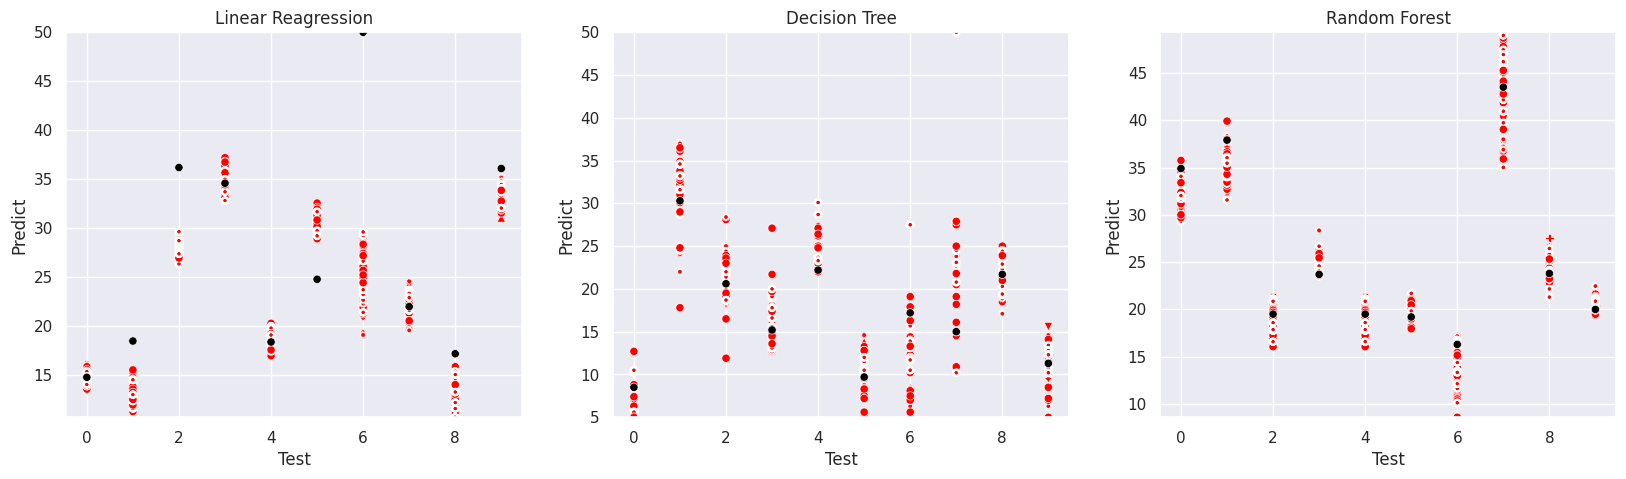

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_predictions(LinearRegression(), X, y, title='Linear Reagression', ax=axes[0])
plot_predictions(DecisionTreeRegressor(), X, y, title='Decision Tree', ax=axes[1])
plot_predictions(RandomForestRegressor(), X, y, title='Random Forest', ax=axes[2])

plt.show()


__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

__Your answer here:__

У линейной модели большое смещение и малый разброс. У деревьев меньше смещение, но больше разброс. Случайный лес показывает лучший результат - меньший разброс и меньшее смещение, чем у предыдущих двух моделей.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [110]:

bias_depth = []
variance_depth = []

for max_depth in range(1, 11):
    b, v, e = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X, y)

    bias_depth.append(b)
    variance_depth.append(v)



bias_feature = []
variance_feature = []

for max_feature in range(1, X.shape[1]):
  b, v, e = compute_biase_variance(DecisionTreeRegressor(max_features=max_feature), X, y)

  bias_feature.append(b)
  variance_feature.append(v)



100%|██████████| 100/100 [00:00<00:00, 172.51it/s]


In [111]:
def plot_errors(x_label, title, data, ax):
    sns.lineplot(data=data,  ax=ax)
    sns.set_style('darkgrid')

    # ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel('value')

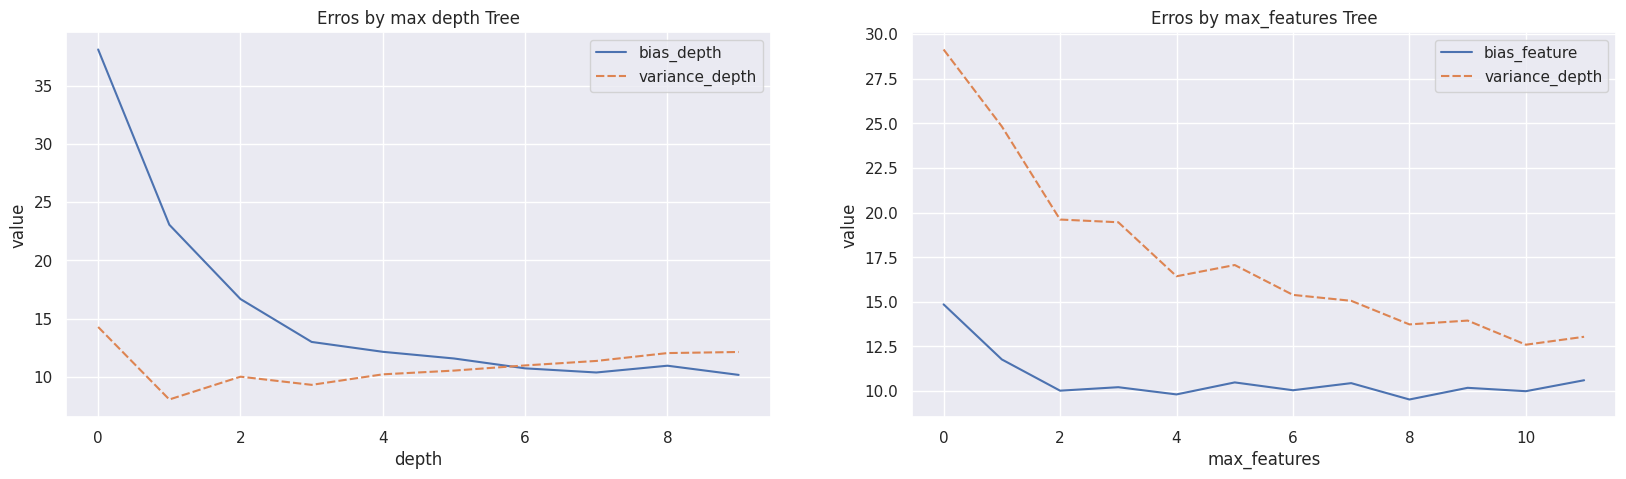

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

plot_errors('depth', 'Erros by max depth Tree', {'bias_depth' : bias_depth, 'variance_depth': variance_depth}, ax=axes[0])

plot_errors('max_features', 'Erros by max_features Tree', {'bias_feature' : bias_feature, 'variance_depth': variance_feature}, ax=axes[1])


__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [113]:
from sklearn.ensemble import GradientBoostingRegressor

bias_forest = []
variance_forest = []

for n_estimator in 2**np.arange(1, 10):
    b, v, e = compute_biase_variance(RandomForestRegressor(n_estimators=n_estimator), X, y)

    bias_forest.append(b)
    variance_forest.append(v)



bias_boosting = []
variance_boosting = []

for n_estimator in 2**np.arange(1, 10):
  b, v, e = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_estimator), X, y)

  bias_boosting.append(b)
  variance_boosting.append(v)


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


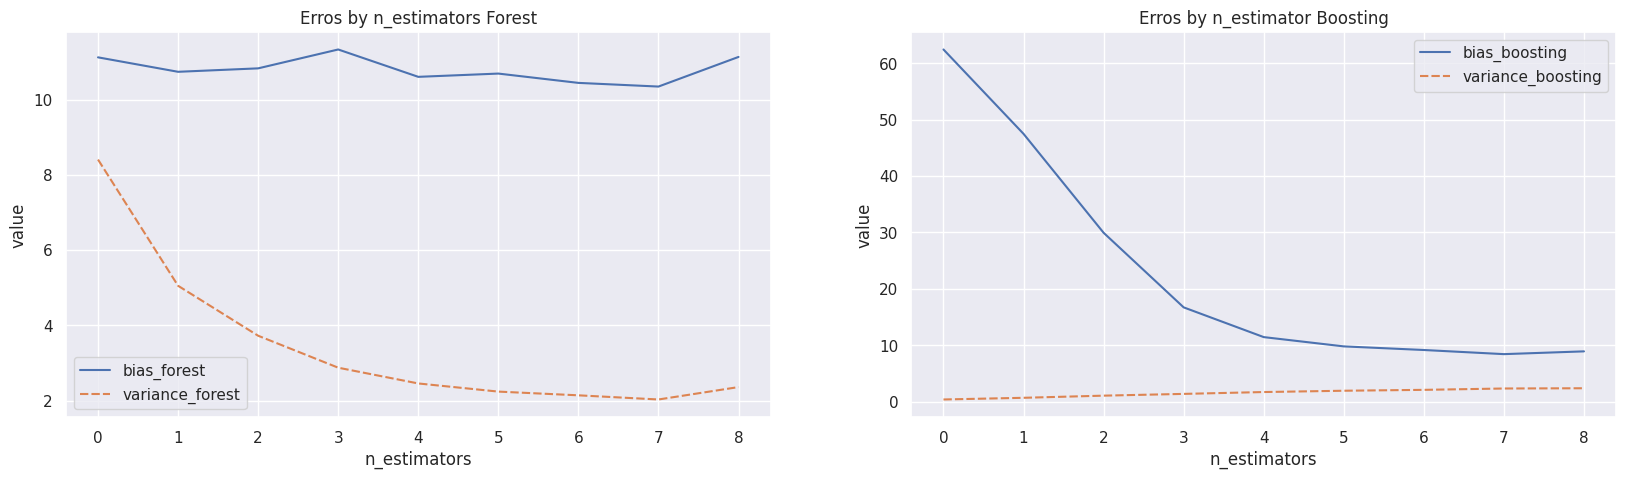

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

plot_errors('n_estimators', 'Erros by n_estimators Forest', {'bias_forest' : bias_forest, 'variance_forest': variance_forest}, ax=axes[0])

plot_errors('n_estimators', 'Erros by n_estimator Boosting', {'bias_boosting' : bias_boosting, 'variance_boosting': variance_boosting}, ax=axes[1])


__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

По первому графику можно понять, что увеличение глубины ведет с снижению смещения и небольшому увеличению дисперсии, потому что деревья легко переобучаются. Второй график показывает уменьшение большого разброса при увеличении количества признаков, потому что большее количество признаков позволяет модели лучше обучаться; смещение немного убывает, потом выходит на что-то типа  плато. Третья картинка рисует нам почти постоянное смещение и убывающий разброс, потому что смещение характеризуется базовым алгоритмом, а разброс старается уменьшиться в n_estimators раз. Последнее произведение машиного искусства иллюстрирует убывающее смещение и низкий почти константный разброс, потому что бустинг использует простые неглубокие деревья, со временем простые модели учатся лучше апроксимировать и смещение снижается.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__